<a href="https://colab.research.google.com/github/lilz827/final-project-303-3/blob/main/Model_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_recall_curve

In [2]:
data = pd.read_csv('stats_unique_no_missing.csv')
data.head()

,Unnamed: 0,player_name,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,...,oreb,dreb,treb,ast,stl,blk,pts,Unnamed: 64,Unnamed: 65,drafted
0,4589,Pooh Williams,Utah St.,WAC,32,64.0,108.3,18.1,53.0,53.33,...,0.4688,1.3750,1.8438,2.1875,0.5938,0.2188,8.7812,Combo G,7.300850,0.0
1,4590,Nick Rodgers,Butler,Horz,11,1.0,121.1,16.8,75.0,75.00,...,0.0000,0.0000,0.0000,0.0909,0.0000,0.0000,0.5455,Pure PG,12.267400,0.0
2,4591,Dana Smith,Longwood,ind,27,81.8,99.8,27.7,49.9,53.76,...,2.1481,4.9259,7.0741,2.4074,0.8148,0.4815,17.5556,Wing F,5.581250,0.0
3,4594,Carlos Strong,Boston University,AE,35,76.2,118.1,16.4,58.8,60.93,...,1.3429,3.2286,4.5714,1.8000,1.6571,0.4000,10.8571,Combo G,6.583070,0.0
4,4595,Sherrod Smith,Boston University,AE,29,9.5,60.7,6.9,8.3,14.93,...,0.1379,0.5862,0.7241,0.2069,0.1034,0.0345,0.1724,Wing G,0.844851,0.0


In [44]:
(data.drafted.value_counts()/data.drafted.shape)*100

0.0    97.436546
1.0     2.563454
Name: drafted, dtype: float64

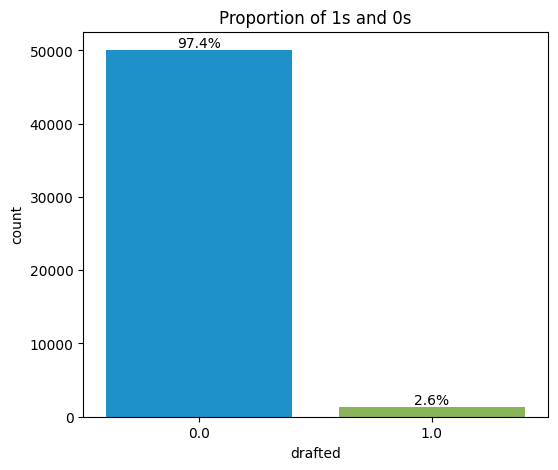

In [51]:
plt.figure(figsize=(6,5))
plt.title("Proportion of 1s and 0s")
ax = sns.countplot(data=data, x='drafted', palette=['#039be5','#8bc34a'])
for c in ax.containers:
    
    labels = [f'{h/data.drafted.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

In [3]:
cols = list(data.columns)
categorical_cols = []
numerical_cols = []
for item in cols:
    if data[item].dtype == object:
        categorical_cols.append(item)
    else:
        numerical_cols.append(item)

In [ ]:
categorical_cols

['player_name', 'team', 'conf', 'yr', 'ht', 'num', 'type', 'Unnamed: 64']

In [4]:
data = data.set_index('player_name')

In [5]:
data = data.drop(['Unnamed: 64', 'Unnamed: 65', 'rimmade+rimmiss', 'midmade+midmiss',
       'dunksmiss+dunksmade', 'num', 'type'], axis=1)
data_dummies = pd.get_dummies(data)

In [6]:
y = data_dummies.drafted
X = data_dummies.drop('drafted', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=45)

In [9]:
params = {'bootstrap': [True],
          'n_estimators': [10, 300, 400, 500],
          'max_depth': [25, 30, 35],
          'max_leaf_nodes': [100, 500, 1000]}

model_group = GridSearchCV(RandomForestClassifier(random_state=45, n_jobs=-1),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
0.14005455200452885 {'bootstrap': True, 'max_depth': 25, 'max_leaf_nodes': 500, 'n_estimators': 500}


<Figure size 800x800 with 0 Axes>

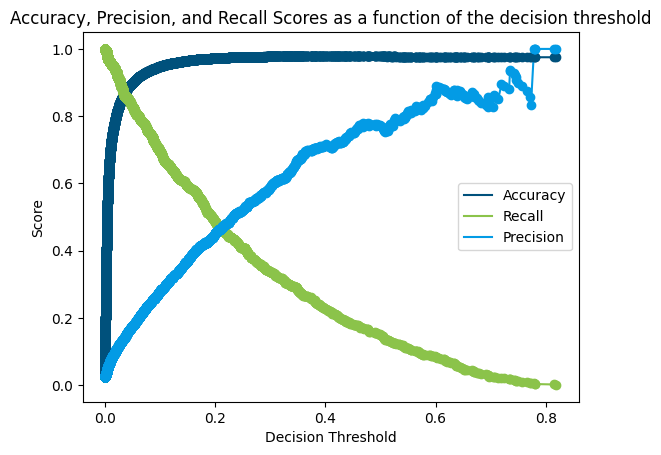

In [16]:
model = RandomForestClassifier(random_state=45, bootstrap=True,
                               n_estimators=500, max_leaf_nodes=500,
                               max_depth=25, n_jobs=-1)
model.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [22]:
desired_threshold = 0.05

ypred_prob_train = model.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.9672343876723439
Train Recall:  1.0
Test Accuracy:  0.9071578025400224
Test Recall:  0.8083182640144665


In [23]:
params = {'base_estimator': [DecisionTreeClassifier(max_depth=10),
                            DecisionTreeClassifier(max_depth=11),
                            DecisionTreeClassifier(max_depth=12)],
          'n_estimators': [5, 10, 50, 100],
          'learning_rate': [0.01, 0.015, 0.02]}

model_group = GridSearchCV(AdaBoostClassifier(random_state=45),
                           params, scoring='recall',
                           cv=3, n_jobs=-1, verbose=1)

model_group.fit(X_train, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.4018218310946426 {'base_estimator': DecisionTreeClassifier(max_depth=11), 'learning_rate': 0.02, 'n_estimators': 10}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

<Figure size 800x800 with 0 Axes>

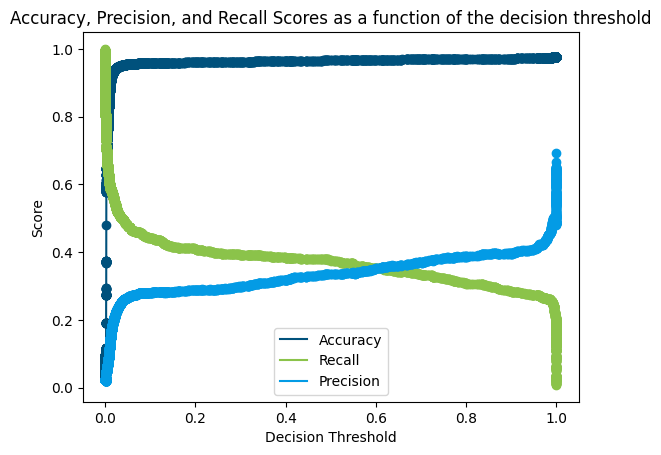

In [33]:
model2 = AdaBoostClassifier(random_state=45, base_estimator=DecisionTreeClassifier(max_depth=11),
                            n_estimators=10, learning_rate=0.02, )
model2.fit(X_train, y_train)

cross_val_ypred = cross_val_predict(model2, X_train, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [35]:
desired_threshold = 0.009

ypred_prob_train = model2.predict_proba(X_train)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model2.predict_proba(X_test)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.906374695863747
Train Recall:  0.9895287958115183
Test Accuracy:  0.8750425770035521
Test Recall:  0.6057866184448463


In [36]:
importance = list(model2.feature_importances_)
name = list(model2.feature_names_in_)
df = pd.DataFrame()
df['Feature Name'] = name
df['Feature Importance'] = importance
df.sort_values(by='Feature Importance', ascending=False).loc[df['Feature Importance']!=0]

,Feature Name,Feature Importance
34,dporpag,1.405551e-01
23,porpag,8.186817e-02
39,gbpm,6.305284e-02
31,dunksmade,3.805592e-02
448,yr_Fr,3.759108e-02
...,...,...
445,conf_WAC,7.118169e-19
455,ht_1-Jun,5.642499e-19
435,conf_OVC,2.460445e-19
117,team_Dayton,1.788407e-19


In [37]:
important_features = list(df.loc[df['Feature Importance']!=0]['Feature Name'])

selected_features = data_dummies[important_features]
X_train_sel, X_test_sel, y_train, y_test = train_test_split(selected_features, y, test_size=0.4, random_state=45)

In [38]:
params = {'base_estimator':[DecisionTreeClassifier(max_depth=8),
                            DecisionTreeClassifier(max_depth=9),
                            DecisionTreeClassifier(max_depth=10)],
          'n_estimators': [15, 20, 25, 30, 35],
          'learning_rate': [0.011, 0.0111, 0.015, 0.02]}

model_group = GridSearchCV(AdaBoostClassifier(random_state=45),
                           params, scoring='recall',
                           cv=5, n_jobs=-1, verbose=1)

model_group.fit(X_train_sel, y_train)
print(model_group.best_score_, model_group.best_params_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.3783023735810113 {'base_estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 0.0111, 'n_estimators': 15}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/en

<Figure size 800x800 with 0 Axes>

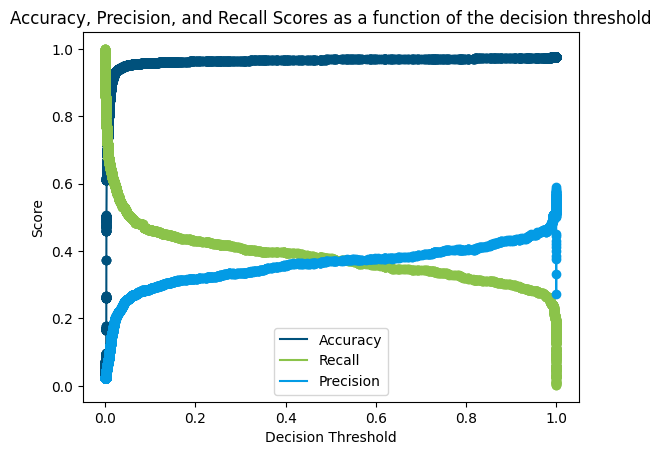

In [39]:
model3 = AdaBoostClassifier(random_state=45, learning_rate=0.0111, 
                            base_estimator=DecisionTreeClassifier(max_depth=10),
                            n_estimators=15)
model3.fit(X_train_sel, y_train)

cross_val_ypred = cross_val_predict(model3, X_train_sel, y_train, cv = 5, method = 'predict_proba')
p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracys = []
for threshold in thresholds:
    ypred = cross_val_ypred[:,1] > threshold
    ypred = ypred.astype(int)
    accuracy = accuracy_score(ypred, y_train)
    accuracys.append(accuracy)
accuracys = np.array(accuracys)     

def plot_accuracy_recall_vs_threshold(recalls, precisions, thresholds):
    plt.figure(figsize=(8, 8))
    plt.figure(facecolor='white')
    plt.title("Accuracy, Precision, and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracys, "-", color="#00517c", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "-", color="#8bc34a", label="Recall")
    plt.plot(thresholds, precisions[:-1], "-", color="#039be5", label="Precision")
    plt.plot(thresholds, accuracys, "o", color="#00517c")
    plt.plot(thresholds, recalls[:-1], "o", color="#8bc34a")
    plt.plot(thresholds, precisions[:-1], "o", color="#039be5")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(r, p, thresholds)

In [40]:
desired_threshold = 0.008

ypred_prob_train = model3.predict_proba(X_train_sel)[:,1] 
ypred_train = ypred_prob_train > desired_threshold
ypred_train = ypred_train.astype(int)

ypred_prob_test = model3.predict_proba(X_test_sel)[:,1] 
ypred_test = ypred_prob_test > desired_threshold
ypred_test = ypred_test.astype(int)

print("Train Accuracy: ", accuracy_score(y_train, ypred_train))
print("Train Recall: ", recall_score(y_train, ypred_train))
print("Test Accuracy: ", accuracy_score(y_test, ypred_test))
print("Test Recall: ", recall_score(y_test, ypred_test))

Train Accuracy:  0.8483698296836983
Train Recall:  0.9882198952879581
Test Accuracy:  0.8203007152936597
Test Recall:  0.6907775768535263
